# QUANTUM BOLTZMANN MACHINE

Quantum Boltzmann Machine (QBM) is a machine learning approach based on quantum Boltzmann distribution and exploiting the rapid growth of the Hilbert space dimension to speed up the classical machine learning algorithm: the Boltzman Machine (BM), when implemented on a quantum hardware. 

In this small research project we try to replicate the results of the following paper: https://arxiv.org/abs/1601.02036. In particular, we focus on its first example (Section 4) of a fully visible model with N variables, this allows to confront the training of classical Boltzmann Machine, quantum Boltzmann Machine and another variant called bound-QBM. 

In the models, a state is associated with an energy function or Hamiltoninan. The goal is to learn the energy parameters b, w, gamma for each of the N variables (spin or qubit), so that the learned distribution of the data (Boltzmann distribution) is as similar as possible to the actual data distribution. The learning is achieved by finding the parameters that minimize the negative log-likelihood. The minimization is done by adjusting the parameters at each step in the opposite direction of the gradient (gradient descent technique). The step size is controlled by a fixed learning rate eta.

All three algorithms are presented below, along with commentary and a final plot to compare the results obtained.

## Classical Boltzmann Machine

In the fully visible BM model, given N spin variables (binary units) that define a state, there are N + N(N-1)/2 trainable parameters: b(a) and w(a,b); gamma = 0 : there are no transverse components of spin. 

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

def energy(z, b, W):
    """ 
    E(z) = - sum_a (b_a z_a) - sum_{a,b} (w_{a,b} z_a z_b)
    for a single configuration z in {+1, -1}^N. 
    """
    # We'll compute this directly:
    #   E(z) = - (b·z + z^T W z)
    bz = np.dot(b, z)
    zWz = np.dot(z, np.matmul(W, z))
    return -(bz + zWz)

def boltzmann_distribution(b, W, all_states):
    """
    Enumerate all states z in {+1, -1}^N, compute
        P_model(z) = exp[-E(z)] / Z
    and return a (2^N,) probability vector.
    """
    energies = []
    for z in all_states:
        E_z = energy(z, b, W)
        energies.append(E_z)
    energies = np.stack(energies)  # shape (2^N)

    # exponentiate -E(z) already appears in 'energies' as negative
    # but we have E_z = -(...) so actually we want exp(-E_z) = exp(+ ...).
    # Let's just do exp(-E_z):
    negE = -energies
    exp_shifted = np.exp(negE)
    Z = exp_shifted.sum()
    return exp_shifted / Z

# Kullback-Leibler (KL) divergence: KL = Likelihood - Likelihood_min
def kl_divergence(P_data, P_model):
    return np.sum(P_data * np.log((P_data + 1e-12)/(P_model + 1e-12)))

# Define Parameters
N = 8  # Number of visible spins z in {+1, -1}
M = 8  # Number of modes for data distribution
p = 0.9 # Spin alignment probability with mode centers
eta = 0.2  # Learning rate
num_steps = 35 # Number of optimization steps

The learning rate parameter is chosen empirically as the one that enables the algorithm to obtain the lowest value of KL divergence, which quantifies the quality of training. The same approach has been applied to the bound-QBM and QBM. 

In [ ]:
# Generate M random center points s^k in {+1, -1}^N
centers = np.random.randint(low=0, high=2, size=(M, N))  # in {0,1}
centers = 2*centers - 1  # map to {+1,-1}

# Enumerate all states z in {+1, -1}^N
all_configs = list(itertools.product([-1, +1], repeat=N))
all_z = np.array(all_configs, dtype=np.float32)  # (2^N, N)

def mixture_data_distribution(all_states, centers, p):  
    """Generate training data as a mixture of M modes using 
        Bernouilli distribution: p^(N-d_kv)*(1-p)^d_kv """
    num_modes = centers.shape[0]  # The number of modes (M=8) is the centers' number of rows
    N_ = centers.shape[1]         # The number of bits (N=10) is the centers' number of columns 
    N_states = all_states.shape[0] # (2^N)
    probs = np.zeros(N_states, dtype=np.float32)
    for s in range(N_states):  
        mode_sum = 0.0
        for k in range(num_modes): 
            d_ks = 0.5 * np.sum(1 - all_states[s, :] * centers[k, :])  # Hamming distance between state s and center k
            mode_sum += p**(N_ - d_ks) * (1 - p)**d_ks  # mixture of Bernoulli distribution
        probs[s] = mode_sum / num_modes   # Generating P_data for each state
    # normalitation
    probs /= probs.sum()
    return probs

P_data = mixture_data_distribution(all_z, centers, p)
print("Check sum of P_data:", P_data.sum().item())  # ~1.0
print("Check dimension of P_data:", P_data.shape)  # ~2^10 = 1024

In the BM fully visible model the gradient steps are expressed in terms of different avergaes called 'positive' and 'negative' phases. The positive and negative phases for each parameter are obtained by averaging the respective spin variable over the data distribution and the model distribution, respectively.

In [ ]:
# Compute 'positive phase' averages once: <z_a>_data, <z_a z_b>_data for each a,b = 1,2,...,N
z_data_avg = np.zeros(N)
zz_data_avg = np.zeros((N, N))
N_states = all_z.shape[0]
for i in range(N_states):
    z_data_avg += P_data[i] * all_z[i, :] 
    zz_data_avg += P_data[i] * np.outer(all_z[i, :], all_z[i, :])

# Manual Gradient Updates Using exact formulas
# Initialize parameters (b, W) using 'random.seed'
np.random.seed(42)
b = 0.01 * np.random.randn(N)
W = 0.01 * np.random.randn(N, N)

kl_history = []
for step in range(num_steps):
    # 1) Compute model distribution
    P_model = boltzmann_distribution(b, W, all_z)
    # 2) 'Negative phase' averages: <z_a>_model, <z_a z_b>_model for each a,b = 1,2,...,N
    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    for i in range(N_states):
      z_model_avg += P_model[i] * all_z[i, :]
      zz_model_avg += P_model[i] * np.outer(all_z[i, :], all_z[i, :])
    
    # Compute gradient steps as difference between positive and negative phases
    db = eta * (z_data_avg - z_model_avg) 
    dW = eta * (zz_data_avg - zz_model_avg)

    b += db
    W += dW
    
    # Compute and save KL value
    this_kl = kl_divergence(P_data, P_model)
    kl_history.append(this_kl.item())

    if step % 5 == 0:
        print(f"Iter {step}: KL = {this_kl.item():.4f}")

# Saving Data frame in CSV
df = pd.DataFrame({"iteration": list(range(num_steps)), "kl_history": kl_history})
df.to_csv("BM.csv", index=False)
print("Dati salvati in BM.csv")

df = pd.read_csv("BM.csv")

### Plotting results of BM

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df['iteration'], df['kl_history'], marker='o', label='KL Divergence')
plt.xlabel("Iteration")
plt.ylabel("KL Divergence")
plt.title("BM Training (Exact)")
plt.grid(True)
plt.show()

## Quantum Boltzmann Machine

In the Quantum Boltzmann Machine, binary spin variables are replaced with (2^N x 2^N) matrices (operators), where N is now the number of quantum bits. The energy function (the model) is therefore replaced with a (2^N x 2^N) Hamiltonian matrix. The Hamiltonian is build in such a way that its diagonal elements correspond to classical energy values for each of the 2^N possible classical states. 

In this fully visible model, each parameter is associated with a (2^N x 2^N) matrix, and gamma is also a parameter to learn, but it is fixed to be the same for each non-diagonal (2^N x 2^N) matrix rapresenting transverse components of spin.

In [66]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Define Parameters
N = 8  # Number of visible qubits
M = 8  # Number of modes for data distribution
p = 0.9  # Spin alignment probability with mode centers
eta = 0.4 # Learning rate (increased)
iterations = 35  # Number of optimization steps

# Pauli Matrices
I = np.array([[1, 0], [0, 1]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_x = np.array([[0, 1], [1, 0]])

# Generate M random center points s^k in {+1, -1}^N
centers = np.random.randint(low=0, high=2, size=(M, N)) # in {0,1}
centers = 2*centers - 1  # map to {+1,-1}

def mixture_data_distribution(all_states, centers, p):  
    """Generate training data as a mixture of M modes using 
        Bernouilli distribution: p^(N-d_kv)*(1-p)^d_kv """
    num_modes = centers.shape[0]  # The number of modes (M=8) is the centers' number of rows
    N_ = centers.shape[1]         # The number of bits (N=10) is the centers' number of columns 
    N_states = all_states.shape[0] # (2^N)
    probs = np.zeros(N_states, dtype=np.float32)
    for s in range(N_states):  
        mode_sum = 0.0
        for k in range(num_modes): 
            d_ks = 0.5 * np.sum(1 - all_states[s, :] * centers[k, :])  # Hamming distance between state s and center k
            mode_sum += p**(N_ - d_ks) * (1 - p)**d_ks  # mixture of Bernoulli distribution
        probs[s] = mode_sum / num_modes   # Generating P_data for each state
    # normalitation
    probs /= probs.sum()
    return probs


In [59]:

def tensor_product(ops):
    """Compute the tensor product of multiple operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result


We report that while trying to speed-up the code we tried to compute the function 'tensor_product' using NUMBA. Unfortunately this didn't seem to make the computation faster. 

In [13]:
from numba import njit

@njit
def tensor_product(ops):
    """Compute the tensor product of multiple operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

In order to optimize the efficiency of the code we computed the (2^N x 2^N) matrices, representing spin operators, only once out of the 'for loops'. This did make the runtime faster: about 5 times faster than creating spin matrices in each cycle.  

In [60]:
# Compute sigma_z(a), sigma_x(a) and sigma_z(a,b) matrices for each a,b = 1,...,N
gamma_sigma = np.zeros((2**N, 2**N))
b_sigma = np.zeros(N, dtype=object)
W_sigma = np.zeros((N, N),dtype=object)
for a in range(N):
    gamma_sigma += tensor_product([I] * a + [sigma_x] + [I] * (N - a - 1))
    b_sigma[a] = tensor_product([I] * a + [sigma_z] + [I] * (N - a - 1)) 
    for b in range(a + 1, N): 
        W_sigma[a,b] = tensor_product([I] * a + [sigma_z] + [I] * (b - a - 1) + [sigma_z] + [I] * (N - b - 1))

In [61]:
def build_states(N):
    all_states = np.zeros((2**N, N))
    for s in range(N):
        all_states[:, s] = np.diag(b_sigma[s])  # each state is a diagonal element of the sigma_z(a) matrices 
    return all_states

def build_hamiltonian(N, Gamma, b, W):
    """Construct the Fully Visible QBM Hamiltonian with a transverse field."""
    H = np.zeros((2**N, 2**N), dtype=complex) # Size (2^N, 2^N)
    H = -Gamma * gamma_sigma  # Transverse field
    H -= np.dot(b, b_sigma) 
    H -= np.sum(W * W_sigma, axis=None) 
    return H

def compute_density_matrix(H):
    """Compute the density matrix rho = e^(-H)/Z"""
    exp_H = expm(-H)  # exp(-H)
    Z = np.trace(exp_H)
    return exp_H / Z, Z

Again trying to speed up the alogirthm, we computed the exponential of the matrix H approximatevely. Even with a very few order of approsimization (n=2), this did make the code a little faster, but it still didn't allow computation for bigger N. Therefore, we ended up using the numpy function 'expm()' in the final results. 

Note: We tried to use Numba for this function as well.

In [16]:
# Approximation of matrix exponentiation
def matrix_exponential_approx(A, n_terms=2):
    result = np.eye(A.shape[0])
    term = np.eye(A.shape[0]) 
    for i in range(1, n_terms + 1):
        term = np.dot(term, A) / i  
        result += term  
    return result

In [62]:
def compute_full_probability_distribution(rho):
    """Return the diagonal elements of rho as the model probability distribution."""
    return np.real(np.diag(rho))

# Kullback-Leibler (KL) divergence: KL = Likelihood - Likelihood_min
def compute_kl_upper_bound(P_data, P_model):
    """Compute the KL divergence upper bound using P_model: diagonal elements of rho."""
    return np.sum(P_data * np.log((P_data + 1e-12)/(P_model + 1e-12)))

In the QBM fuly visible model, the gradient steps for each parameter are obtained by computing the difference of the expetation value of the derivative of the matrix exp(-H) projected on a visible state, averaged over the actual data distribution of all states, and the expectation value of the respective operator matrix (Boltzmann averaging). 

In [63]:
# Building derivative to compute "positive phase"
def compute_partial_expH(H, rho, Z, projector, partial_H, n):
   avg_v = 0.0
   delta_t = 1.0 / n
   trace = np.trace(projector @ (rho * Z))
   exp_tH = expm(-delta_t * H) # we compute only once exp_th in order to optimize efficiency
   exp1 = np.eye(H.shape[0])
   for m in range(1, n + 1):
      t = m * delta_t
      exp1 = exp1 @ exp_tH  # e^(-τH)
      exp2 = expm((t - 1) * H) # e^{-(1-τ)H}
      avg_v += np.trace(projector @ exp1 @ partial_H @ exp2) / (trace + 1e-12) * delta_t
   return -avg_v

# Compute "positive" and "negative phase" averages: <sigma_z_a>, <sigma_z_a sigma_z_b> for each a,b = 1,2,...,N

state_proj = np.zeros((2**N, 2**N))

def compute_gradient_update(P_data, H, rho, Z, all_states, N, eta):
    """Compute the gradient updates for the QBM parameters."""
    n = 2   # To allow computation we kept at minimum the iteration steps of the 'compute_partial_expH' function
    global state_proj

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N)) 

    N_states = all_states.shape[0]
    partial_expH_Gamma = np.zeros(N_states)
    for z in range(N_states):
        state_proj[z, z] = 1
        partial_expH_Gamma[z] = compute_partial_expH(H, rho, Z, state_proj, gamma_sigma, n)
        state_proj[z, z] = 0

    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      Gamma_data_avg = 0.
      for z in range(N_states):
            state_proj[z, z] = 1
            z_data_avg[a] += P_data[z] * compute_partial_expH(H, rho, Z, state_proj, b_sigma[a], n)
            Gamma_data_avg += P_data[z] * partial_expH_Gamma[z]
            state_proj[z, z] = 0
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @  W_sigma[a,b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]  # Ensure symmetry
         for z in range(N_states):
            state_proj[z, z] = 1
            zz_data_avg[a, b] += P_data[z] * compute_partial_expH(H, rho, Z, state_proj,  W_sigma[a, b], n)
            #zz_data_avg[b, a] = zz_data_avg[a, b]  
            state_proj[z, z] = 0
             
    Gamma_model_avg = np.trace(rho @ gamma_sigma).real

    # Compute gradient steps as difference between positive and negative phases
    delta_b = -eta * (z_data_avg + z_model_avg)
    delta_W = -eta * (zz_data_avg + zz_model_avg)
    delta_Gamma = -eta * (Gamma_data_avg + Gamma_model_avg)

    return delta_b, delta_W, delta_Gamma

Our last attempt to speed-up the computation, to be able to compute the machine learning algorithm for bigger number of qubits N, was to substitute the function 'compute_partial_expH' with a Fortran function that computed the same derivative. Analizying the code we noticed that this one was the computationally most demanding function and removing it would allow the algorithm to run for N=10. Indeed this function was the main and only difference from the b-QBM algorithm which did run for bigger N (N=10).
We implemented a Fortran test function that only computed a trace of a matrix (H) to verify the speed-up. The test was run with N=10.

#### Fortran test function

subroutine test(A, N, avg)

    integer, intent(in) :: N

    real, dimension(1024, 1024), intent(in) :: A

    real, intent(out) :: avg
    
    integer :: i

    avg=0.
    do i = 1, 2**N
      avg = avg + A(i,i)
    end do
end subroutine test

#Note: 'python3 -m numpy.f2py -c -m  test  test.f90' to compile the Fortran f2py module to be able to import it in Python

In [ ]:
import sys
sys.path.append('/filepath')
import test

N=10
state_proj = np.zeros((2**N, 2**N))

def compute_gradient_update(P_data, H, rho, Z, all_states, N, eta):
    """Compute the gradient updates for the QBM parameters."""
    global state_proj

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N)) 

    N_states = all_states.shape[0]
    partial_expH_Gamma = np.zeros(N_states)
    for z in range(N_states):
        state_proj[z, z] = 1
        partial_expH_Gamma[z] = test.test(H, N)
        state_proj[z, z] = 0

    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      Gamma_data_avg = 0.
      for z in range(N_states):
            state_proj[z, z] = 1
            z_data_avg[a] += P_data[z] * test.test(H, N)
            Gamma_data_avg += P_data[z] * partial_expH_Gamma[z]
            state_proj[z, z] = 0
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @  W_sigma[a,b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]  # Ensure symmetry
         for z in range(N_states):
            state_proj[z, z] = 1
            zz_data_avg[a, b] += P_data[z] * test.test(H, N)
            #zz_data_avg[b, a] = zz_data_avg[a, b]  
            state_proj[z, z] = 0
             
    Gamma_model_avg = np.trace(rho @ gamma_sigma).real

    # Compute gradient steps as difference between positive and negative phases
    delta_b = -eta * (z_data_avg + z_model_avg)
    delta_W = -eta * (zz_data_avg + zz_model_avg)
    delta_Gamma = -eta * (Gamma_data_avg + Gamma_model_avg)

    return delta_b, delta_W, delta_Gamma

We then computed the same test function using numpy, as before we tested it with N=10.

In [ ]:
def test(H):
    avg = np.trace(H)
    return avg

N=10
state_proj = np.zeros((2**N, 2**N))

def compute_gradient_update(P_data, H, rho, Z, all_states, N, eta):
    """Compute the gradient updates for the QBM parameters."""
    global state_proj

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N)) 

    N_states = all_states.shape[0]
    partial_expH_Gamma = np.zeros(N_states)
    for z in range(N_states):
        state_proj[z, z] = 1
        partial_expH_Gamma[z] = test(H)
        state_proj[z, z] = 0

    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      Gamma_data_avg = 0.
      for z in range(N_states):
            state_proj[z, z] = 1
            z_data_avg[a] += P_data[z] * test(H)
            Gamma_data_avg += P_data[z] * partial_expH_Gamma[z]
            state_proj[z, z] = 0
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @  W_sigma[a,b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]  # Ensure symmetry
         for z in range(N_states):
            state_proj[z, z] = 1
            zz_data_avg[a, b] += P_data[z] * test(H)
            #zz_data_avg[b, a] = zz_data_avg[a, b]  
            state_proj[z, z] = 0
             
    Gamma_model_avg = np.trace(rho @ gamma_sigma).real

    # Compute gradient steps as difference between positive and negative phases
    delta_b = -eta * (z_data_avg + z_model_avg)
    delta_W = -eta * (zz_data_avg + zz_model_avg)
    delta_Gamma = -eta * (Gamma_data_avg + Gamma_model_avg)

    return delta_b, delta_W, delta_Gamma

We found that the runtime was slower with the Fortran function. This led us to abandon the implementation with Fortran.

![Python test](Python_test_runtime.jpeg)
![Fortran test](Fortran_test_runtime.jpeg)

In [ ]:
def optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations):
    """Optimize the Fully Visible Bound-Based QBM."""

    kl_divergence = []
    for it in range(iterations):
        H = build_hamiltonian(N, Gamma, b, W)
        rho,_ = compute_density_matrix(H)
        _,Z = compute_density_matrix(H)

        # Compute model distribution
        P_model = compute_full_probability_distribution(rho)

        # Compute and save KL value
        KL_bound = compute_kl_upper_bound(P_data, P_model)
        kl_divergence.append(KL_bound)
        
        delta_b, delta_W, delta_Gamma = compute_gradient_update(P_data, H, rho, Z, all_states, N, eta)
        b += delta_b
        W += delta_W
        Gamma += delta_Gamma

        print(f"Iteration {it+1}/{iterations}, KL Divergence: {KL_bound:.6f}, Δb={np.linalg.norm(delta_b):.6f}, Δw={np.linalg.norm(delta_W):.6f}")
    return kl_divergence

# Initialize parameters (b, W, Gamma) using 'random.seed'
np.random.seed(42)
b = 0.1 * np.random.randn(N)
W = 0.1 * np.random.randn(N, N)
Gamma = 0.1 * np.random.rand()

all_states = build_states(N)
P_data = mixture_data_distribution(all_states, centers, p)
print("Check sum of P_data:", P_data.sum().item())  # ~1.0
print("Check dimension of P_data:", P_data.shape)  # ~2^10 = 1024
print(type(P_data))

# Optimize the Fully Visible QBM
kl_divergence = optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations)

# Saving Data frame in CSV
df = pd.DataFrame({"iteration": range(1, iterations + 1), "kl_divergence": kl_divergence})
df.to_csv("FullyVisible_QBM.csv", index=False)
print("Dati salvati in FullyVisible_QBM.csv")

df = pd.read_csv("FullyVisible_QBM.csv")

### Plotting results of QBM

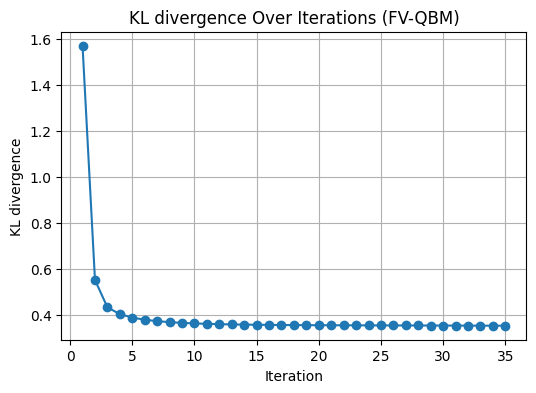

In [69]:
# Plot KL divergence upper bound over iterations
plt.figure(figsize=(6, 4))
plt.plot(df['iteration'], df['kl_divergence'], marker='o', label='KL divergence over Iterations')
plt.xlabel("Iteration")
plt.ylabel("KL divergence")
plt.title("KL divergence Over Iterations (FV-QBM)")
plt.grid()
plt.show()

## bound - Quantum Boltzmann Machine

In [ ]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# Define Parameters
N = 8  # Number of visible qubits
M = 8  # Number of modes for data distribution
p = 0.9  # Spin alignment probability with mode centers
eta = 0.9 # Learning rate (increased)
iterations = 35  # Number of optimization steps
Gamma = 2 # Fixed transverse field strength

# Pauli Matrices
I = np.array([[1, 0], [0, 1]])
sigma_z = np.array([[1, 0], [0, -1]])
sigma_x = np.array([[0, 1], [1, 0]])

# Generate M random center points s^k in {+1, -1}^N
centers = np.random.randint(low=0, high=2, size=(M, N)) # in {0,1}
centers = 2*centers - 1  # map to {+1,-1}

def mixture_data_distribution(all_states, centers, p):  
    """Generate training data as a mixture of M modes using 
        Bernouilli distribution: p^(N-d_kv)*(1-p)^d_kv """
    num_modes = centers.shape[0]  # The number of modes (M=8) is the centers' number of rows
    N_ = centers.shape[1]         # The number of bits (N=10) is the centers' number of columns 
    N_states = all_states.shape[0] # (2^N)
    probs = np.zeros(N_states, dtype=np.float32)
    for s in range(N_states):  
        mode_sum = 0.0
        for k in range(num_modes): 
            d_ks = 0.5 * np.sum(1 - all_states[s, :] * centers[k, :])  # Hamming distance between state s and center k
            mode_sum += p**(N_ - d_ks) * (1 - p)**d_ks  # mixture of Bernoulli distribution
        probs[s] = mode_sum / num_modes   # Generating P_data for each state
    # normalitation
    probs /= probs.sum()
    return probs

def tensor_product(ops):
    """Compute the tensor product of multiple operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

# Compute sigma_z(a), sigma_x(a) and sigma_z(a,b) matrices for each a,b = 1,...,N
b_sigma = np.zeros(N, dtype=object)
gamma_sigma = np.zeros((2**N, 2**N))
W_sigma = np.zeros((N, N),dtype=object)
for a in range(N):
    gamma_sigma += tensor_product([I] * a + [sigma_x] + [I] * (N - a - 1))
    b_sigma[a] = tensor_product([I] * a + [sigma_z] + [I] * (N - a - 1)) 
    for b in range(a + 1, N): 
        W_sigma[a, b] = tensor_product([I] * a + [sigma_z] + [I] * (b - a - 1) + [sigma_z] + [I] * (N - b - 1))

def build_states(N):
    all_states = np.zeros((2**N, N))
    for s in range(N):
        all_states[:, s] = np.diag(b_sigma[s])  # each state is a diagonal element of the sigma_z(a) matrices 
    return all_states

def build_hamiltonian(N, Gamma, b, W):
    """Construct the Fully Visible QBM Hamiltonian with a transverse field."""
    H = np.zeros((2**N, 2**N), dtype=complex) # Size (2^N, 2^N)
    H = -Gamma * gamma_sigma  # Transverse field
    H -= np.dot(b, b_sigma)  
    H -= np.sum(W * W_sigma, axis=None)  
    return H

def compute_density_matrix(H):
    """Compute the density matrix rho = exp(-H) / Z."""
    exp_H = expm(-H)
    Z = np.trace(exp_H)
    rho = exp_H / Z
    return rho, Z

def compute_full_probability_distribution(rho):
    """Compute the full probability distribution P_v from diagonal elements of rho."""
    return np.real(np.diag(rho))  # Extract diagonal elements as probabilities

# Kullback-Leibler (KL) divergence: KL = Likelihood - Likelihood_min
def compute_kl_upper_bound(P_data, P_model):
    """Compute the KL divergence upper bound using P_model: diagonal elements of rho."""
    return np.sum(P_data * np.log((P_data + 1e-12)/(P_model + 1e-12)))

In [ ]:
# Compute "positive" and "negative phase" averages: <sigma_z_a>, <sigma_z_a sigma_z_b> for each a,b = 1,2,...,N
def compute_gradient_update(P_data, rho, all_states, N, eta):
    """Compute gradient updates for b and w."""

    z_model_avg = np.zeros(N)
    zz_model_avg = np.zeros((N, N))
    z_data_avg = np.zeros(N)
    zz_data_avg = np.zeros((N, N))

    # Negative phase
    N_states = all_states.shape[0]
    for a in range(N):
      z_model_avg[a] = np.trace(rho @ b_sigma[a]).real
      for b in range(a + 1, N):
         zz_model_avg[a, b] = np.trace(rho @ W_sigma[a, b]).real
         #zz_model_avg[b, a] = zz_model_avg[a, b]
    
    # Positive phase
    N_states = all_states.shape[0]
    for i in range(N_states):
        z_data_avg += P_data[i] * all_states[i, :]
        zz_data_avg += P_data[i] * np.outer(all_states[i, :], all_states[i, :])

    # Compute gradient steps as difference between positive and negative phases
    delta_b = eta * (z_data_avg - z_model_avg)
    delta_W = eta * (zz_data_avg - zz_model_avg)
    return delta_b, delta_W

def optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations):
    """Optimize the Fully Visible Bound-Based QBM."""

    kl_upper_bounds = []
    for it in range(iterations):
        H = build_hamiltonian(N, Gamma, b, W)
        rho, _ = compute_density_matrix(H)

        # Compute model distribution
        P_model = compute_full_probability_distribution(rho)
        
        # Compute and save KL value
        KL_bound = compute_kl_upper_bound(P_data, P_model)
        kl_upper_bounds.append(KL_bound)
        
        delta_b, delta_W = compute_gradient_update(P_data, rho, all_states, N, eta)
        b += delta_b
        W += delta_W

        print(f"Iteration {it+1}/{iterations}, KL Upper Bound: {KL_bound:.6f}, Δb={np.linalg.norm(delta_b):.6f}, Δw={np.linalg.norm(delta_W):.6f}")
    return kl_upper_bounds

# Initialize parameters (b, W) using 'random.seed'
np.random.seed(42)
b = 0.01 * np.random.randn(N)
W = 0.01 * np.random.randn(N, N)

all_states = build_states(N)
P_data = mixture_data_distribution(all_states, centers, p)
print("Check sum of P_data:", P_data.sum().item())  # ~1.0
print("Check dimension of P_data:", P_data.shape)  # ~2^10 = 1024
print(type(P_data))

# Optimize the Fully Visible Bound-Based QBM
kl_upper_bounds = optimize_qbm(P_data, all_states, N, Gamma, b, W, eta, iterations)

# Saving Data frame in CSV
df = pd.DataFrame({"iteration": range(1, iterations + 1), "kl_upper_bounds": kl_upper_bounds})
df.to_csv("FullyVisible_bQBM.csv", index=False)
print("Dati salvati in FullyVisible_bQBM.csv")

df = pd.read_csv("FullyVisible_bQBM.csv")

### Plotting results of b-QBM

In [ ]:
# Plot KL divergence upper bound over iterations
plt.figure(figsize=(6, 4))
plt.plot(df['iteration'], df['kl_upper_bounds'], marker='o', label='KL Upper Bound over Iterations')
plt.xlabel("Iteration")
plt.ylabel("KL Upper Bound")
plt.title("KL Upper Bound Over Iterations (FV-bQBM)")
plt.grid()
plt.show()

### Plotting results of BM, QBM and b-QBM all together for a comparison

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/andreadecristofaro/BM.csv"
df = pd.read_csv(file_path)
plt.plot(df['iteration'], df['kl_history'], marker='o', color='green', label='BM_N=8')

file_path = "/Users/andreadecristofaro/FullyVisible_bQBM.csv"
df = pd.read_csv(file_path)
plt.plot(df['iteration'], df['kl_upper_bounds'], marker='o', color='red', label='bQBM_N=8')

file_path = "/Users/andreadecristofaro/FullyVisible_QBM.csv"
df = pd.read_csv(file_path)
plt.plot(df['iteration'], df['kl_divergence'], marker='o', color='blue', label='QBM_N=8')

plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("KL divergence Over Iterations")
plt.legend()
plt.grid()
plt.show()
